# Project 4 - Dealing with West Nile Virus in Chicago
---

## Problem Statement and Executive Summary
---

- [West Nile Virus (WNV)](https://www.cdc.gov/westnile/index.html) is the leading cause of mosquito-borne disease in the America. It is most commonly spread to people through the bite of an infected mosquito. Cases of WNV occur during the mosquito season, which begins in the summer and continues through autumn. There are no vaccines to prevent or medications to cure WNV in people. Around 1 in 5 people who are infected develop a fever and other symptoms, while about 1 out of 150 infected people develop a serious, sometimes fatal, illness.


- Our team is tasked to predict the existence of WNV given areas in Chicago, as well as conduct a cost-benefit analysis of deploying the spraying of pesticides.


- This will inform policy formulation and resource planning by the government to optimize protection of Chicago residents from the virus.


- Exploratory Data Analysis (EDA) will first be conducted on the various datasets provided. Train and Test data would be merged so that they could be cleaned together and columns standardized. Dates will be broken down into days, months, and years and dummies would be created for categorical features such as "Species", as well as specific features such as months, then weather data will be cleaned and merged to both train and test datasets, before finally splitting the dataset into train and test sets.


- The simplest and most widely used classification algorithm, Logistic Regression will first be trained and evaluated on the train set using cross_val_score to get a rough gauge of its performance, model will then be tuned, before more complex models such as bagging ensemble methods like Random Forest or boosting ensemble methods like XGBoost would be run on the train dataset to evaluate the same. 


- Chosen model will have its hyperparameters tuned using GridSearchCV and final deployment/production model will be evaluated using a mixture of ROC AUC and metrics such as recall in. As it is more important to capture as many wnv-prone spots as possible, there will be increased emphasis on the recall (sensitivity) metric when we evaluate our models. The model will also be used to predict WNV for the test data and the predictions generated will be submitted to Kaggle (metric used was ROC AUC) to compare against the public leaderboard. Our chosen model achieved a decent ROC AUC of ~0.69 on Kaggle.

- The details will be outlined in the following sections.

## Data Cleaning and Initial EDA
---

- Importing relevant libraries first...

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train=pd.read_csv('../data/train.csv')
train.head(3)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0


In [3]:
test=pd.read_csv('../data/test.csv')
test.head(3)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


Text(0.5, 1.0, 'Number of Mosquitos by Street')

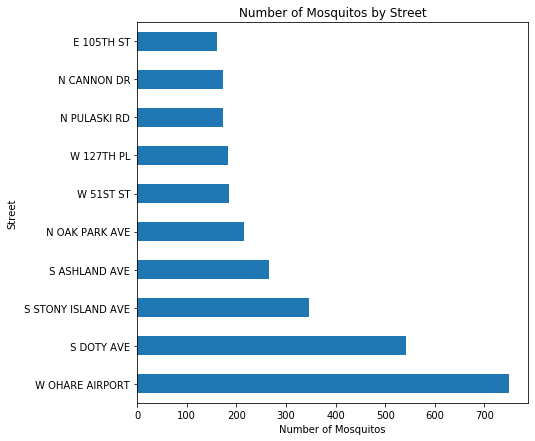

In [4]:
#Getting a rough gauge which streets tend to attract the most number of mosquitos in Chicago...
strt_mozzies = train.groupby('Street')['NumMosquitos'].count().sort_values(ascending=False).head(10)
strt_mozzies.plot.barh(figsize=(7,7))
plt.xlabel("Number of Mosquitos")
plt.title("Number of Mosquitos by Street")

Text(0.5, 1.0, 'Number of Mosquitos by Trap')

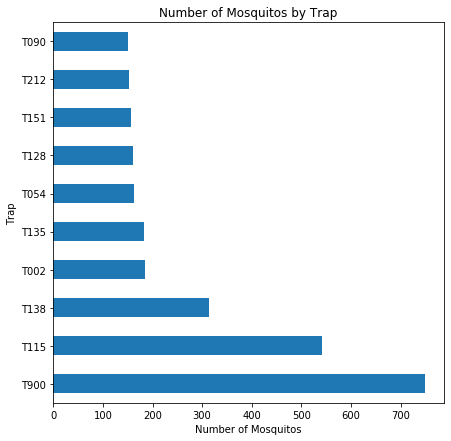

In [5]:
#Getting a rough sense which traps tend to be either most effective in trapping mosquitos or happened to be deployed in areas with the highest mosquito concentrations..
train.groupby('Trap')['NumMosquitos'].count().sort_values(ascending=False).head(10).plot.barh(figsize=(7,7))
plt.xlabel("Number of Mosquitos")
plt.title("Number of Mosquitos by Trap")

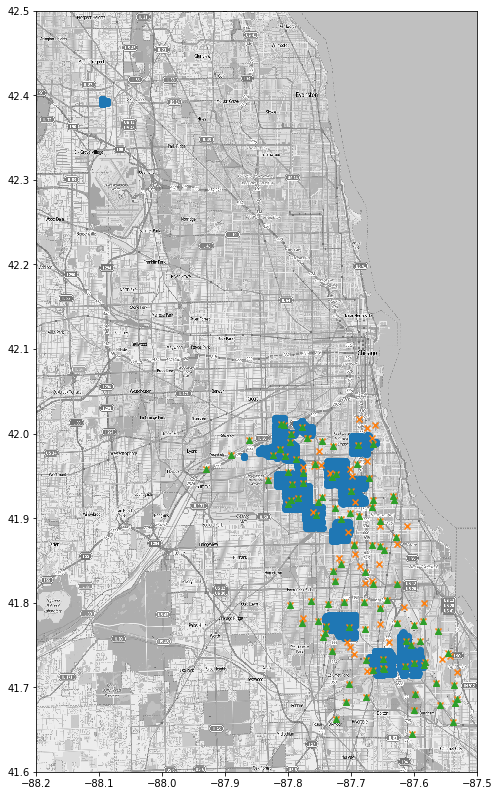

In [6]:
mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../data/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]
spray = pd.read_csv('../data/spray.csv')[['Date', 'Time', 'Latitude', 'Longitude']]
#spray_datetime = spray.copy()
#spray_datetime['Date'] = pd.to_datetime(spray['Date'])

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88.2, -87.5, 41.6, 42.5)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
#locations_spray_2011 = spray_datetime[spray_datetime.Date.dt.year == 2011][['Longitude', 'Latitude']].drop_duplicates().values
locations_spray = spray[['Longitude', 'Latitude']].drop_duplicates().values
locations_wnvpresent = traps[traps['WnvPresent']==1][['Longitude','Latitude']].drop_duplicates().values

plt.scatter(locations_spray[:,0], locations_spray[:,1], marker='o');
plt.scatter(locations[:,0], locations[:,1], marker='x');
plt.scatter(locations_wnvpresent[:,0], locations_wnvpresent[:,1], marker='^');

- The above shows regions where spraying efforts in 2011 and 2013 were concentrated (spraying patterns appear correlated over space-indicating spatial dependence), as well as where traps were deployed and where wnv was present in 2007, 2009, 2011, and 2013. The map plot seems to suggest that while some of the sprays were conducted on wnv-present areas, not all were covered. Particularly, the south-eastern region of chicago, middle portion, that contain traps with wnv present were not sprayed in 2011 and 2013. Based in this initial EDA, perhaps the city of chocago can concentrate spraying in these areas instead. 


- There appears to be a cluster of sprays concentrated in the top left-hand corner of the map plot (lat = ~42.4, long = ~ -88.1) that appears to be an "outlier" cluster... Let's dig deeper into the number.

- Alluding to the seemingly "outlier" cluster showcased in the mapplot above, it is a cluster of 95 spray instances all conducted on 29 Aug 2011 across various time points...There were no traps deployed there and no wnv present too... So why were those 95 spray instances conducted there?! 

In [7]:
train[train['WnvPresent']==1][['Latitude','Longitude']].describe()

,Latitude,Longitude
count,551.000000,551.000000
mean,41.854891,-87.724663
std,0.120243,0.104362
min,41.644612,-87.930995
25%,41.731922,-87.800991
50%,41.903002,-87.725057
75%,41.973967,-87.642984
max,42.011601,-87.531635


In [8]:
spray[(spray['Latitude']>42.3) & (spray['Longitude']<-88.0)]

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
...,...,...,...,...
90,2011-08-29,7:14:38 PM,42.392902,-88.093853
91,2011-08-29,7:14:48 PM,42.392587,-88.093867
92,2011-08-29,7:14:58 PM,42.392308,-88.093873
93,2011-08-29,7:15:18 PM,42.392183,-88.093767


In [9]:
train['WnvPresent']

0        0
1        0
2        0
3        0
4        0
        ..
10501    1
10502    0
10503    0
10504    0
10505    0
Name: WnvPresent, Length: 10506, dtype: int64

In [10]:
train['Date'] = pd.to_datetime(train['Date'])

In [11]:
train['Month'] = train['Date'].dt.month

In [12]:
train['Year'] = train['Date'].dt.year

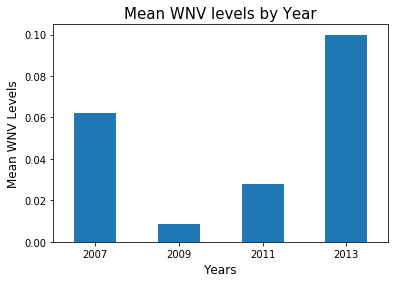

In [13]:
train.groupby('Year')['WnvPresent'].mean().plot.bar()
plt.title('Mean WNV levels by Year', fontsize=15)
plt.ylabel('Mean WNV Levels', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.xticks(rotation=0);

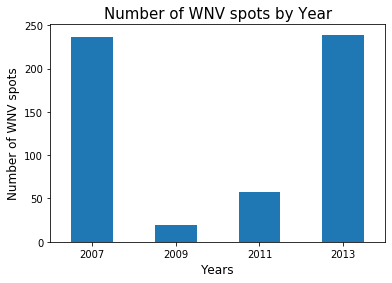

In [14]:
train.groupby('Year')['WnvPresent'].sum().plot.bar()
plt.title('Number of WNV spots by Year', fontsize=15)
plt.ylabel('Number of WNV spots', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.xticks(rotation=0);

In [15]:
spray = pd.read_csv('../data/spray.csv')

In [16]:
spray.head(3)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157


In [17]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [18]:
spray.Date.value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

In [19]:
spray.shape

(14835, 4)

In [20]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [21]:
spray['Date'] = pd.to_datetime(spray['Date'])

In [22]:
spray['Year'] = spray['Date'].dt.year

In [23]:
spray['count'] = 1

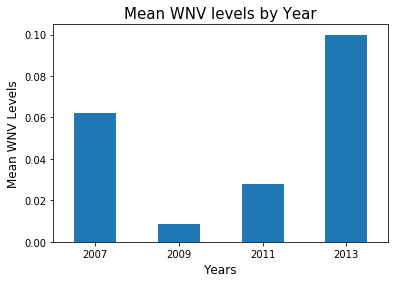

In [24]:
train.groupby('Year')['WnvPresent'].mean().plot.bar()
plt.title('Mean WNV levels by Year', fontsize=15)
plt.ylabel('Mean WNV Levels', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.xticks(rotation=0);

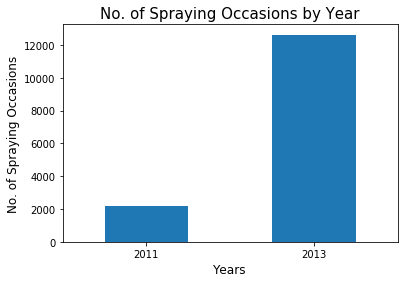

In [25]:
spray.groupby('Year')['count'].sum().plot.bar()
plt.title('No. of Spraying Occasions by Year', fontsize=15)
plt.ylabel('No. of Spraying Occasions', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.xticks(rotation=0);

Based on the above two barplots, there could be several interpretations - It could suggest that the spraying in 2011 did not help to curb WNV occurence which was why in 2013, the WNV occurence went up which led authorities to ramp up efforts in spraying, resulting in a higher number of spraying occasions in 2013. That said, there could be significantly more spraying occasions conducted in 2007 that resulted in WNV occurences declining considerably but we would not be able to confirm this due to the lack of 2009 data.  On the other hand, the barplots could also suggest that the effect of the pesticide sprays conducted each year is only effective within the year and thus comparisons across years could not be made - in which case, the barplots could be interpreted to mean that since there were few WNV occurences in 2011 compared to 2013, it is logical that there were more spraying occasions conducted in 2013 than in 2011. In summary, since we have insufficient years of spray data (2011, 2013 out of 2007-2014), we have excluded the subsequent use of spray data in the modelling process.

## Source(s)
---
- https://www.cdc.gov/westnile/index.html